In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [11]:

def plot_results(filename):
    # 1. Load and process the data
    with open(filename, 'r') as f:
        data = json.load(f)

    records = []
    for config in data.values():
        num_envs = config['num_envs']
        batch_size = config['train_batch_size']
        for t_data in config['times'].values():
            timers = t_data['timers']
            records.append({
                'num_envs': num_envs,
                'batch_size': batch_size,
                'fps': t_data['fps'],
                'total': timers.get('training_iteration', 1),
                'sampling': timers.get('env_runner_sampling_timer', 0),
                'learning': timers.get('learner_update_timer', 0),
            })

    df = pd.DataFrame(records).groupby(['num_envs', 'batch_size']).mean().reset_index()

    # 2. Plotting FPS Scaling
    plt.figure(figsize=(10, 6))
    for bs in df['batch_size'].unique():
        subset = df[df['batch_size'] == bs]
        plt.plot(subset['num_envs'], subset['fps'], marker='o', label=f'Batch: {bs}')

    plt.xscale('log')
    plt.xlabel('Number of Environments (Log Scale)')
    plt.ylabel('Frames Per Second (FPS)')
    plt.title('Throughput Scaling: Batch Size vs. Environments')
    plt.legend()
    plt.grid(True, alpha=0.3)

    connector_records = []
    for config in data.values():
        label = f"E:{config['num_envs']} B:{config['train_batch_size']}"
        for t_data in config['times'].values():
            record = {'label': label, **t_data.get('learner_connector', {})}
            connector_records.append(record)

    # Aggregate and identify major contributors
    df = pd.DataFrame(connector_records).groupby('label').mean()
    major_cols = df.sum().sort_values(ascending=False).index[:5].tolist()
    df['others'] = df.drop(columns=major_cols).sum(axis=1)

    # Generate stacked bar chart
    df[major_cols + ['others']].plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.title('Learner Connector Pipeline Breakdown')
    plt.ylabel('Time (seconds)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

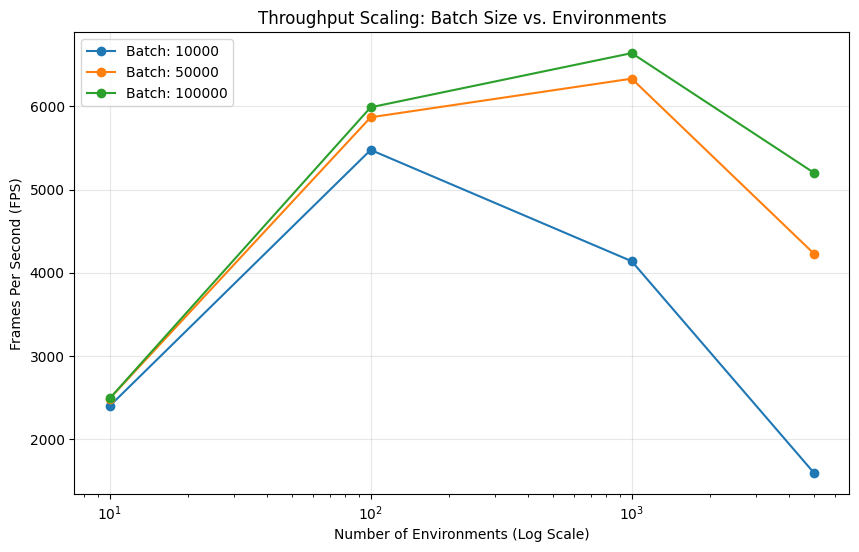

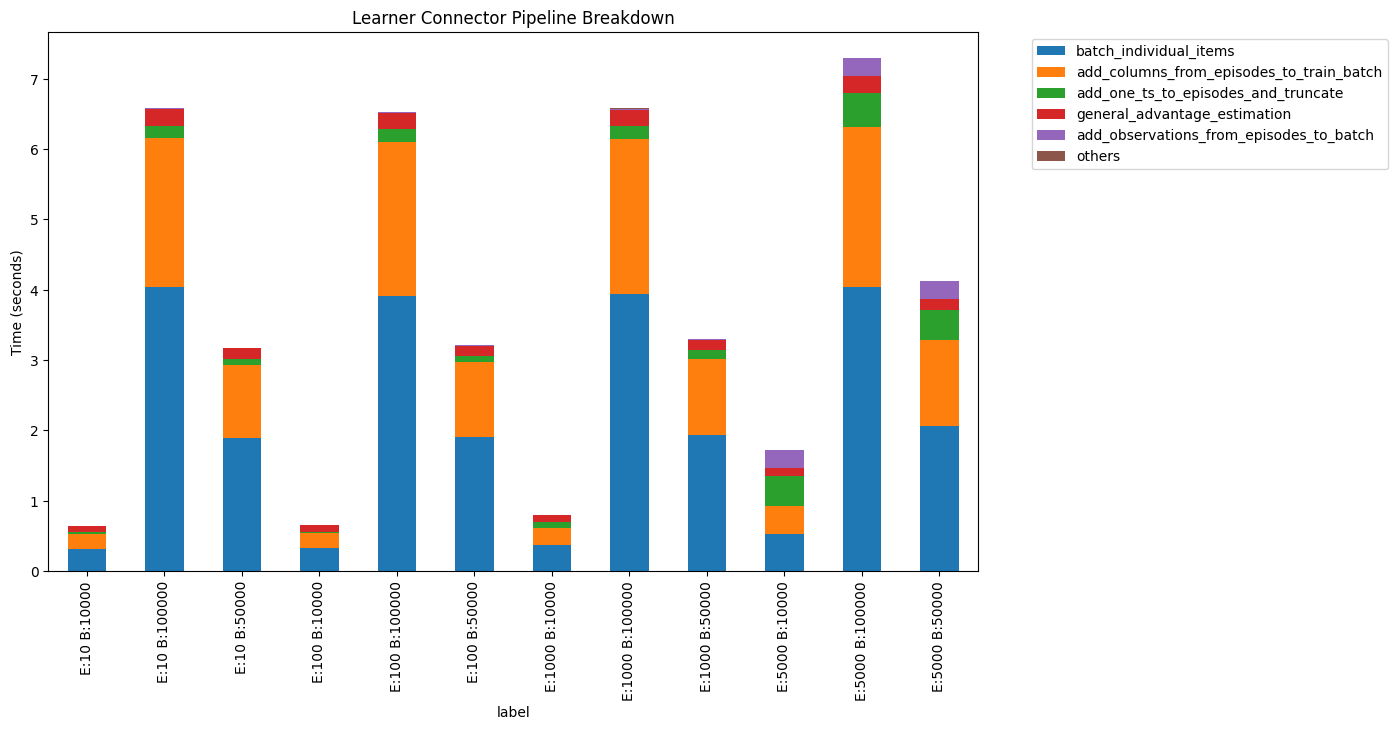

In [ ]:

logdir = ...

plot_results(os.path.join(logdir, 'vec_data.json'))

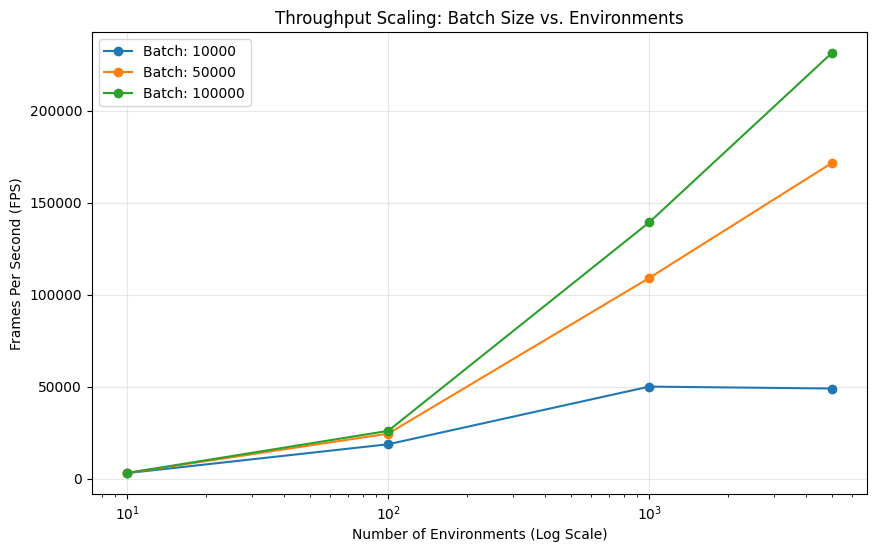

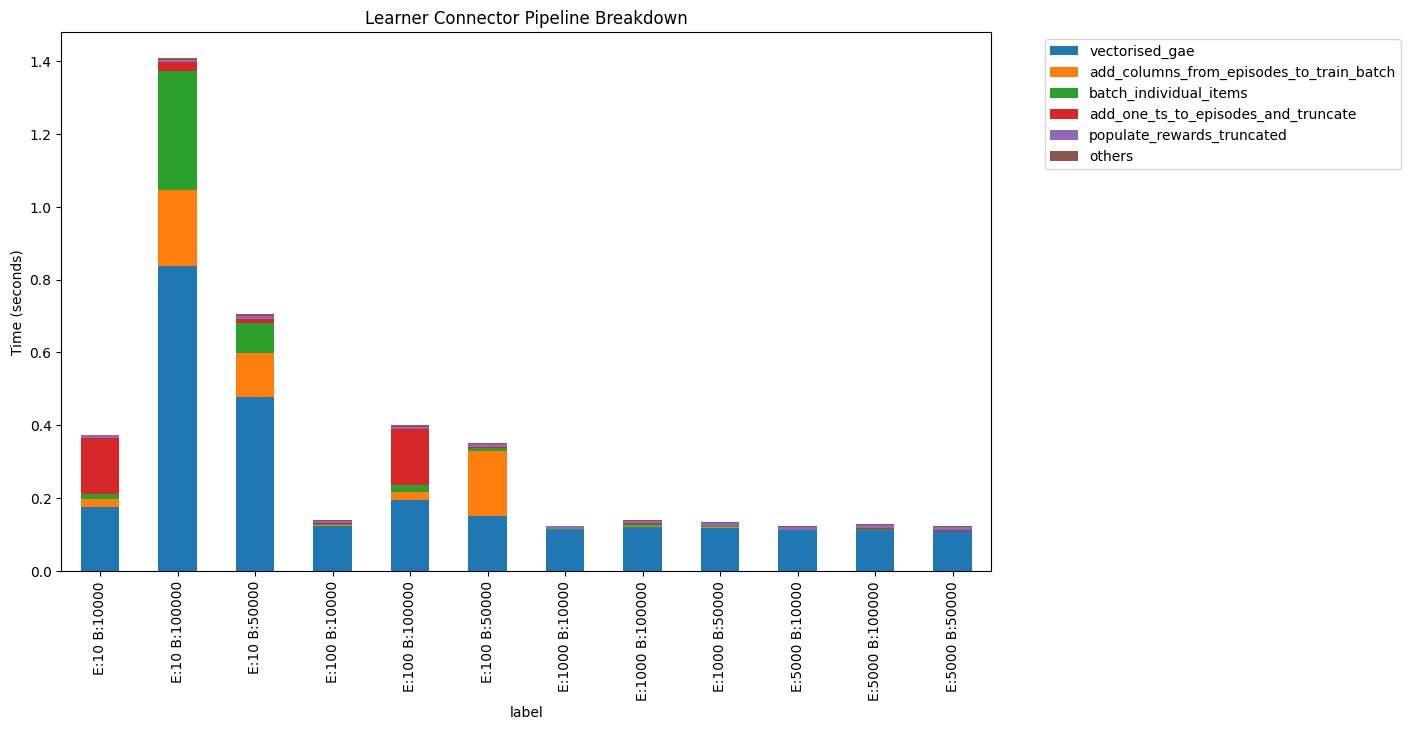

In [15]:
plot_results(os.path.join(logdir, 'packed_vec_data.json'))